In [1]:
import torch
import random
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# plt.style.use('seaborn-pastel')

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
# %pylab widgetsnbextension

In [2]:
# !pip install ipywidgets
# !jupyter lab nbextension enable --py widgetsnbextension

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('../data/MNIST_data', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('../data/MNIST_data', download=True, train=False)

In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

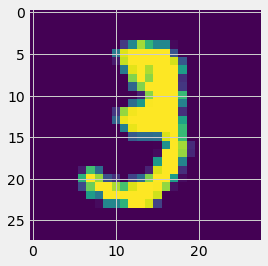

tensor(3)


In [9]:
plt.imshow(X_train[10, :, :])
plt.show()
print(y_train[10])

In [10]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [11]:
# добавил денс слои обратной пирамидой (div 2)
# скорее для увеличения точности

class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        
        half_hidden = int(n_hidden_neurons/2)
        q_hidden = int(half_hidden/2)
        n8_hidden = int(q_hidden/2)
        n16_hidden = int(n8_hidden/2)
        
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, half_hidden) 
        self.ac2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(half_hidden, q_hidden) 
        self.ac3 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(q_hidden, n8_hidden) 
        self.ac4 = torch.nn.ReLU()
        self.fc5 = torch.nn.Linear(n8_hidden, n16_hidden) 
        self.ac5 = torch.nn.ReLU()
        
        self.fc6 = torch.nn.Linear(n16_hidden, 10) 

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        x = self.ac3(x)
        x = self.fc4(x)
        x = self.ac4(x)
        x = self.fc5(x)
        x = self.ac5(x)
        x = self.fc6(x)
        return x


In [12]:
# изменил колв-во нейронов в первом слое
mnist_net = MNISTNet(512)

In [13]:
torch.cuda.is_available()

True

In [14]:
# !nvidia-smi

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# для параллельной обработки на GPUS
# if torch.cuda.device_count() > 1:
#     mnist_net = nn.DataParallel(mnist_net, device_ids=[0,1,3])


mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [16]:
loss = torch.nn.CrossEntropyLoss()

# уменьшил шаг спуска - более гладский спуск
# optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-4)
optimizer = torch.optim.RMSprop(mnist_net.parameters(), lr=1.0e-4)

In [17]:
%%time
# уменьшим батч
batch_size = 30
# увеличим кол-во эпох
EPOCHS = 50

train_accuracy_history = []
test_accuracy_history = []

train_loss_history = []
test_loss_history = []


X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(EPOCHS):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        loss_value = loss(preds, y_batch)
        
        # добавляем метрики для train в конце каждлой эпохи
        if start_index >= len(X_train)-batch_size:
            train_loss_history.append(loss_value)
            train_accuracy = (preds.argmax(dim=1) == y_batch).float().mean()
            train_accuracy_history.append(train_accuracy)
            print(f'EPOCH: {epoch:2d}  Train accuracy = {train_accuracy}')
        
        loss_value.backward()
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test))
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(f'EPOCH: {epoch:2d}  Test accuracy  = {accuracy}')

EPOCH:  0  Train accuracy = 0.9333333969116211
EPOCH:  0  Test accuracy  = 0.9549999833106995
EPOCH:  1  Train accuracy = 0.9666666984558105
EPOCH:  1  Test accuracy  = 0.9695000052452087
EPOCH:  2  Train accuracy = 0.9666666984558105
EPOCH:  2  Test accuracy  = 0.9734999537467957
EPOCH:  3  Train accuracy = 1.0
EPOCH:  3  Test accuracy  = 0.9787999987602234
EPOCH:  4  Train accuracy = 1.0
EPOCH:  4  Test accuracy  = 0.9797999858856201
EPOCH:  5  Train accuracy = 1.0
EPOCH:  5  Test accuracy  = 0.9818999767303467
EPOCH:  6  Train accuracy = 1.0
EPOCH:  6  Test accuracy  = 0.9801999926567078
EPOCH:  7  Train accuracy = 0.9666666984558105
EPOCH:  7  Test accuracy  = 0.9771999716758728
EPOCH:  8  Train accuracy = 1.0
EPOCH:  8  Test accuracy  = 0.9764999747276306
EPOCH:  9  Train accuracy = 1.0
EPOCH:  9  Test accuracy  = 0.9824999570846558
EPOCH: 10  Train accuracy = 0.9666666984558105
EPOCH: 10  Test accuracy  = 0.972000002861023
EPOCH: 11  Train accuracy = 1.0
EPOCH: 11  Test accuracy 

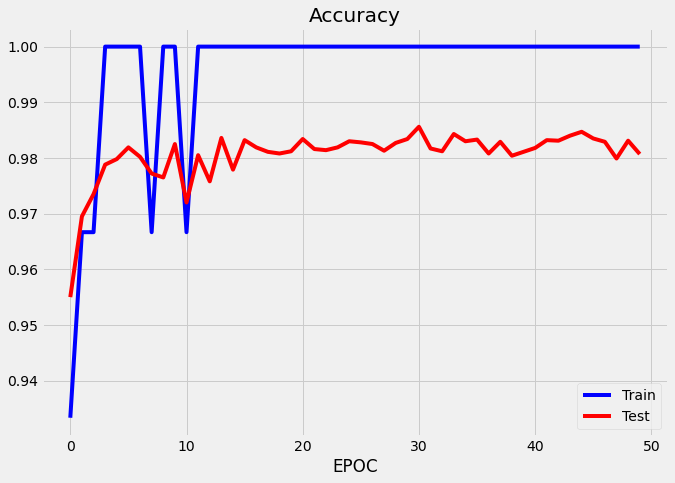

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_title('Accuracy')
ax.set_xlabel('EPOC')
ax.plot(train_accuracy_history, 'b', label='Train' )
ax.plot(test_accuracy_history, 'r', label='Test' )
ax.legend()

plt.show()


In [19]:
idx_acc_max = np.argmax(test_accuracy_history)
print(f'Max accuracy = {test_accuracy_history[idx_acc_max]}, index = {idx_acc_max}, Loss = {test_loss_history[idx_acc_max]}')

Max accuracy = 0.9855999946594238, index = 30, Loss = 0.12180863320827484


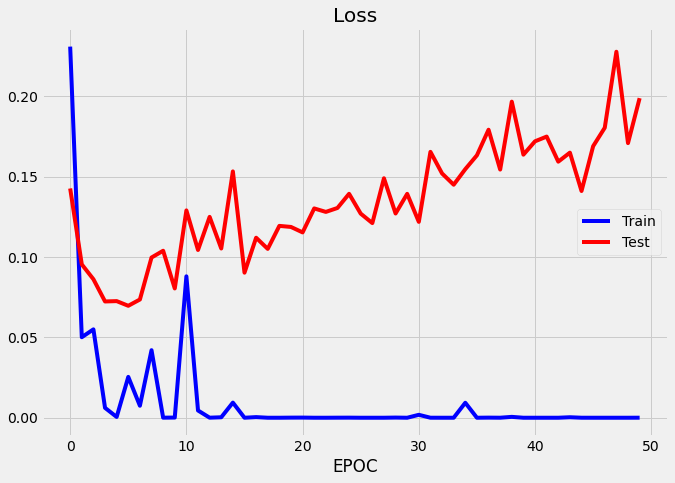

In [20]:
fig, ax = plt.subplots(figsize=(10, 7))

ax.set_title('Loss')
ax.set_xlabel('EPOC')
ax.plot(train_loss_history, 'b', label='Train');
ax.plot(test_loss_history, 'r', label='Test');
ax.legend()

plt.show()


In [21]:
idx_loss_min = np.argmin(test_loss_history)
print(f'Min loss = {test_loss_history[idx_loss_min]}, index = {idx_loss_min}, Accuracy = {test_accuracy_history[idx_loss_min]}')

Min loss = 0.06962297856807709, index = 5, Accuracy = 0.9818999767303467


<b>Наблюдение:</b>
<p>
Следующие параметры привели к переобучению
<ol>
    <li> Смена активации слоев на RELU </li>
    <li> Смена оптимизатора на RMSprop и выставление ему шага 1.0e-4 </li>
    <li> Увеличиние кол-ва эпох и уменьшение батча также ведет к переобучению </li>
    <li> Увеличиние кол-ва слоев увеличило точность модели </li>
    <li> Остальные параметры существенного влияния именно на переобучение не имели </li>
</ol>
